In [ ]:
# Ensure correct environment for GPy
import numpy, os, signal
if numpy.__version__ != "1.26.4":
    # 1. Uninstall conflicting packages
    !pip uninstall -y jax scipy jaxlib paramz pytensor > /dev/null 2>&1
    # 2. Install the versions required for GPy
    !pip install --force-reinstall numpy==1.26.4 scipy GPy paramz > /dev/null 2>&1
    # 3. Restart runtime to load correct NumPy ABI
    os.kill(os.getpid(), signal.SIGKILL)

!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1a.mat > /dev/null
!wget -q https://mlg.eng.cam.ac.uk/teaching/4f13/2526/cw/cw1e.mat > /dev/null
!wget -q https://raw.githubusercontent.com/cambridge-mlg/4f13-courseworks/refs/heads/main/2526/cw1/gp.py > /dev/null

In [2]:
import GPy
import numpy as np
import gp as cw1utils
import math
import matplotlib.pyplot as plt

In [3]:
### Arbitrary data, X and y
X = np.random.rand(20, 1) * 10  # 20 data points in 1D
y = np.sin(X) + (np.cos(X))**2 + np.random.randn(20, 1) * 0.5  # noisy opipbservations

## Loading Matlab arrays in Python

In [4]:
import scipy.io as sio

In [5]:
data = sio.loadmat("cw1a.mat")  # Note this will throw an error because the file does not exist!

X = np.asarray(data["x"], dtype=float)
y = np.asarray(data["y"], dtype=float)

## GP Model Definition with Various Kernels (using GPy):

### Single kernels

Squared exponential (SE) isotropic



In [6]:
k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale= np.exp(-1), variance=1.0) # for ℓ = e^{-1} and σ_f² = 1

#kernel lengthscale l, kernel variance σ² _f and noise variance σ² _n

m = GPy.models.GPRegression(X, y, k)
m.likelihood.variance = 1.0  # for σ_n² Note that this is the default value, so we don't strictly need to set it here unless we want a different initial value.

Squared exponential (SE) isotropic but with multiple initialisations for question c


Found 4 distinct local optima out of 25 starts.

[1] NLML=11.899 | ell=0.1282, sf=0.897, sn=0.118 | ΔNLML=0.000 | evidence ratio=1.000
[2] NLML=78.220 | ell=8.0421, sf=0.696, sn=0.663 | ΔNLML=66.321 | evidence ratio=0.000
[3] NLML=106.348 | ell=0.0018, sf=0.015, sn=0.999 | ΔNLML=94.449 | evidence ratio=0.000
[4] NLML=106.349 | ell=0.0001, sf=0.668, sn=0.743 | ΔNLML=94.450 | evidence ratio=0.000


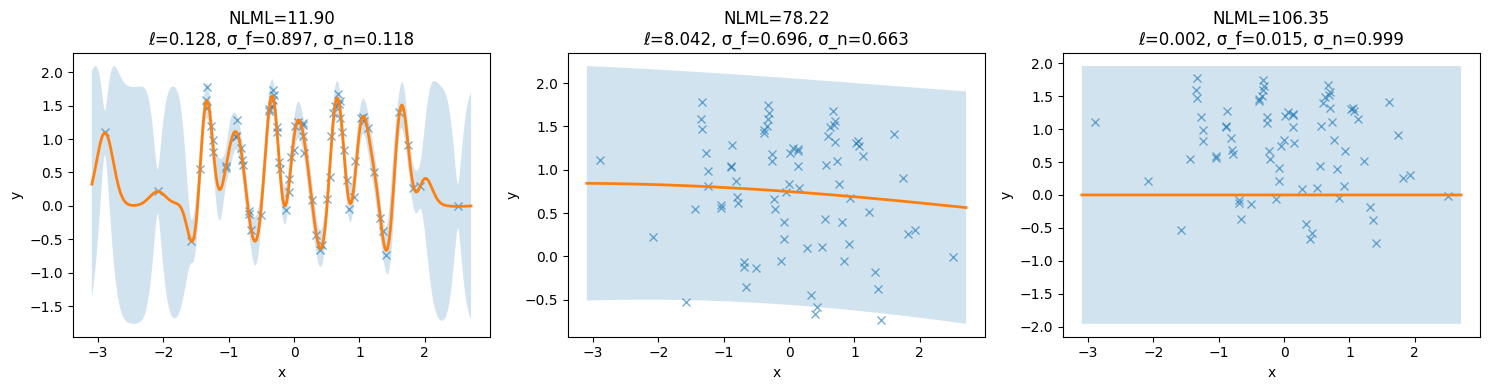

In [9]:

rng = np.random.default_rng(0)  # reproducible

# ---- helper: fit once from a given init ----
def fit_from_init(X, y, l_init, sf2_init, sn2_init, max_iters=2000, messages=False):
    k = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=l_init, variance=sf2_init)
    m = GPy.models.GPRegression(X, y, k)
    m.likelihood.variance = sn2_init
    m.optimize(messages=messages, max_iters=max_iters)
    nlml = -m.log_likelihood()
    pars = {
        "ell": float(m.kern.lengthscale.values),
        "sf2": float(m.kern.variance.values),
        "sn2": float(m.likelihood.variance.values),
    }
    return m, nlml, pars

# ---- random multi-starts on log-scale (broad but reasonable) ----
# ranges chosen to encourage different behaviours (very smooth ↔ very wiggly, noisy ↔ low-noise)
log_ell_range = (-10.0, 1.0)   # ell in [e^-4, e^1] ~ [0.018, 2.718]
log_sf2_range = (-10.0, 1.0)   # sf^2 in [e^-2, e^1] ~ [0.135, 2.718]
log_sn2_range = (-10.0, 0.0)   # sn^2 in [e^-4, 1]  ~ [0.018, 1.0]

num_starts = 25
fits = []

for _ in range(num_starts):
    l0   = float(np.exp(rng.uniform(*log_ell_range)))
    sf20 = float(np.exp(rng.uniform(*log_sf2_range)))
    sn20 = float(np.exp(rng.uniform(*log_sn2_range)))
    m, nlml, pars = fit_from_init(X, y, l0, sf20, sn20)
    fits.append({"model": m, "nlml": nlml, **pars})

# ---- deduplicate local optima (treat params within a tolerance as same optimum) ----
def near(p, q, rtol=5e-2, atol=1e-3):
    return (abs(p["ell"]-q["ell"]) <= atol + rtol*abs(q["ell"]) and
            abs(p["sf2"]-q["sf2"]) <= atol + rtol*abs(q["sf2"]) and
            abs(p["sn2"]-q["sn2"]) <= atol + rtol*abs(q["sn2"]))

unique = []
for f in sorted(fits, key=lambda d: d["nlml"]):
    if not any(near(f, u) for u in unique):
        unique.append(f)

print(f"Found {len(unique)} distinct local optima out of {num_starts} starts.\n")

# ---- report the top few and evidence ratios ----
best = min(unique, key=lambda d: d["nlml"])
for i, f in enumerate(sorted(unique, key=lambda d: d["nlml"])[:5], 1):
    dnlml = f["nlml"] - best["nlml"]
    # evidence ratio ~ exp(-ΔNLML) (Bayes factor vs best under flat hyperpriors)
    ev_ratio = math.exp(-dnlml)
    print(f"[{i}] NLML={f['nlml']:.3f} | ell={f['ell']:.4f}, sf={math.sqrt(f['sf2']):.3f}, "
          f"sn={math.sqrt(f['sn2']):.3f} | ΔNLML={dnlml:.3f} | evidence ratio={ev_ratio:.3f}")

# ---- visualise the best 3 fits ----
def plot_fit(ax, model, title):
    Xtest = np.linspace(X.min()-0.2, X.max()+0.2, 400)[:, None]
    mu, var = model.predict(Xtest)
    sd = np.sqrt(var)
    ax.plot(X, y, "x", alpha=0.6, label="train")
    ax.plot(Xtest, mu, lw=2, label="mean")
    ax.fill_between(Xtest.ravel(), (mu-1.96*sd).ravel(), (mu+1.96*sd).ravel(), alpha=0.2, label="95% CI")
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("y")

top3 = sorted(unique, key=lambda d: d["nlml"])[:3]
fig, axes = plt.subplots(1, len(top3), figsize=(5*len(top3), 4), squeeze=False)
for ax, f in zip(axes.ravel(), top3):
    title = (f"NLML={f['nlml']:.2f}\nℓ={f['ell']:.3f}, σ_f={math.sqrt(f['sf2']):.3f}, σ_n={math.sqrt(f['sn2']):.3f}")
    plot_fit(ax, f["model"], title)
plt.tight_layout()
plt.show()


Periodic

In [6]:
k = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

SE Automatic Relevance Determination (ARD)

In [ ]:
k = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=1.0, variance=1.0)
m = GPy.models.GPRegression(X, y, k)

### Combined kernels

Product of Periodic and SE Isotropic

In [ ]:
k_per = GPy.kern.StdPeriodic(input_dim=X.shape[1], lengthscale=1.0, period=1.0, variance=1.0)
k_se  = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=1.0, variance=1.0)
kernel = k_per * k_se
m = GPy.models.GPRegression(X, y, kernel)

Question d specifications

In [ ]:
# 1) Inputs (dense grid, column vector)
X = np.linspace(-5.0, 5.0, 200, dtype=np.float64).reshape(-1, 1)

# 2) Kernels with the SPECIFIED hyperparameters
#    RBF: ℓ = e^2, σ_f^2 = 1.0
k_se  = GPy.kern.RBF(input_dim=1, lengthscale=float(np.exp(2.0)), variance=1.0)
#    StdPeriodic: ℓ = e^{-0.5}, p = 1.0, σ_f^2 = 1.0
k_per = GPy.kern.StdPeriodic(input_dim=1, lengthscale=float(np.exp(-0.5)), period=1.0, variance=1.0)

# 3) Product kernel
kernel = k_se * k_per

# 4) Build covariance on X and add small jitter for numerical stability
K = kernel.K(X, X)
jitter = 1e-6  # << small positive number; prevents Cholesky failures
K = K + jitter * np.eye(X.shape[0])

# 5) Sample noise-free functions from the GP prior
rng = np.random.default_rng(0)
n_samples = 5
Y = rng.multivariate_normal(mean=np.zeros(X.shape[0]), cov=K, size=n_samples)

# 6) Plot
plt.figure(figsize=(8,4))
for i in range(n_samples):
    plt.plot(X.ravel(), Y[i], lw=1.8, alpha=0.9)
plt.title("Samples from GP prior with kernel = RBF(ℓ=e²) × StdPeriodic(ℓ=e^{-0.5}, p=1)")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(True, alpha=0.2)
plt.show()


Sum of two SE ARD Kernels

In [ ]:
z = np.random.randn(4)
ell1 = np.exp(z[0])
sf1  = np.exp(z[1])
var1 = sf1**2

ell2 = np.exp(z[2])
sf2  = np.exp(z[3])
var2 = sf2**2

k1 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell1, variance=var1)
k2 = GPy.kern.RBF(input_dim=X.shape[1], ARD=True, lengthscale=ell2, variance=var2)
k  = k1 + k2

m = GPy.models.GPRegression(X, y, kernel=k)

## GP Model Hyperparameter Optimisation using Marginal Likelihood

Once a GP regression model is specified, we can optimise its hyperparameters by minimising the negative log marginal likelihood (which is equivalent to maximising the likelihood of the data under the model.)

In [7]:
m.optimize(optimizer='lbfgsb', max_iters=2000, messages=False)

## Utilities functions useful for producing figures to be included in report

MODEL SUMMARY
NEGATIVE LOG MARGINAL LIKELIHOOD: -35.2669
OPTIMISED HYPERPARAMETERS:
  • lengthscale (ℓ): 0.515491
  • signal std (σ_f): 1.16432
  • period (p): 0.998847
  • noise std (σ_n): 0.109855
LML: 35.266945
  • Data fit term: -37.500023
  • Complexity penalty: -141.687358
  • Constant term: -68.920390


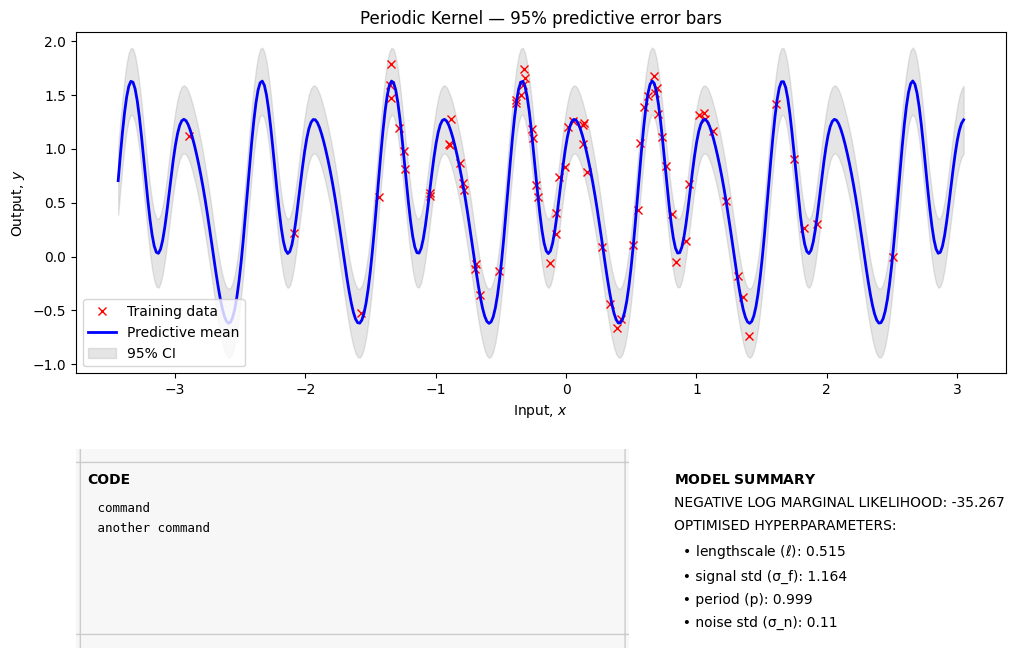

In [8]:
cw1utils.print_model_summary(m)
cw1utils.print_model_marginal_likelihood(m)
cw1utils.plot_predictive_error_bars(m, X, y, "\n command\n another command")

# cw1utils.plot_2d_predictive(mA, mB, codeA=None, codeB=None, save_path=None)
# cw1utils.plot_sampled_functions(X, F, code_snippet, n_draws=3, save_path=None)